In [0]:
#!git clone https://github.com/fanweiya/fish-segmentation.git
import os
os.chdir('/content/fish-segmentation')
import sys
sys.path.append('/content/fish-segmentation/src')
%matplotlib inline


In [0]:
import numpy as np
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from FishDataset import FishDataset
from PIL import Image
from sklearn.model_selection import train_test_split

In [0]:
import re
import numpy as np
import random
import tarfile
import urllib
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset

class FishDataset(Dataset):
    """Fishes dataset."""

    def __init__(self, root_dir, transform=None, target_transform=None, download=False):
        """
        Args:
            root_dir (string): Data directory containing the fish_image and mask_image folders.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.root_dir = os.path.abspath(root_dir)
        self.transform = transform
        self.target_transform = target_transform

        if download:
            self.download()


        self.images = glob(os.path.join(root_dir, 'fish_image/*/*.png'))
        self.masks = [re.sub('fish', 'mask', image) for image in self.images]
        self.labels = [int(re.search('.*fish_image/fish_(\d+)', image).group(1)) for image in self.images]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        label = self.labels[index]
        image = Image.open(self.images[index])
        mask = Image.open(self.masks[index])

        if mask.mode == '1':
            mask = mask.convert('L')

        # https://github.com/pytorch/vision/issues/9
        seed = np.random.randint(2147483647)
        random.seed(seed)
        if self.transform is not None:
            image = self.transform(image)

        random.seed(seed)
        if self.target_transform is not None:
            mask = self.target_transform(mask)
            mask = mask.round()

        return (image, mask, label)


    def download(self):
        if self._check_exists():
            return

        try:
            os.makedirs(self.root_dir)
        except FileExistsError:
            pass

        url = 'http://groups.inf.ed.ac.uk/f4k/GROUNDTRUTH/RECOG/Archive/fishRecognition_GT.tar'
        file_path = os.path.join(self.root_dir, 'fishRecognition_GT.tar')
        print('Downloading...', end=' ')
        urllib.request.urlretrieve(url, file_path)
        print('Done!')
        print('Extracting files...', end=' ')
        with tarfile.open(file_path) as tar:
                tar.extractall(self.root_dir)
        os.remove(file_path)
        print('Done!')

    def _check_exists(self):
        return os.path.exists(os.path.join(self.root_dir, 'fish_image')) and \
               os.path.exists(os.path.join(self.root_dir, 'mask_image'))

fish_dataset = FishDataset('../data')

In [10]:
unet = torch.load('/content/models/unet.pt')

AttributeError: ignored

In [0]:
def extract_fish(image, model):
    original_shape = image.size
    image = image.resize((128, 128))
    inputs = Variable(transforms.ToTensor()(image).unsqueeze(0)).cuda()
    outputs = model(inputs).round().squeeze(0).cpu().data
    mask = transforms.ToPILImage()(outputs)
    background = Image.new('RGB', (128, 128), color='white')
    
    return Image.composite(image, background, mask).resize(original_shape)

In [0]:
# use the same random_sate to get the same validation set from traning
_, test_indices = train_test_split(np.arange(len(fish_dataset)), test_size=0.2, random_state=42)

In [0]:
images = [fish_dataset[i][0] for i in test_indices[:10]]

NameError: ignored

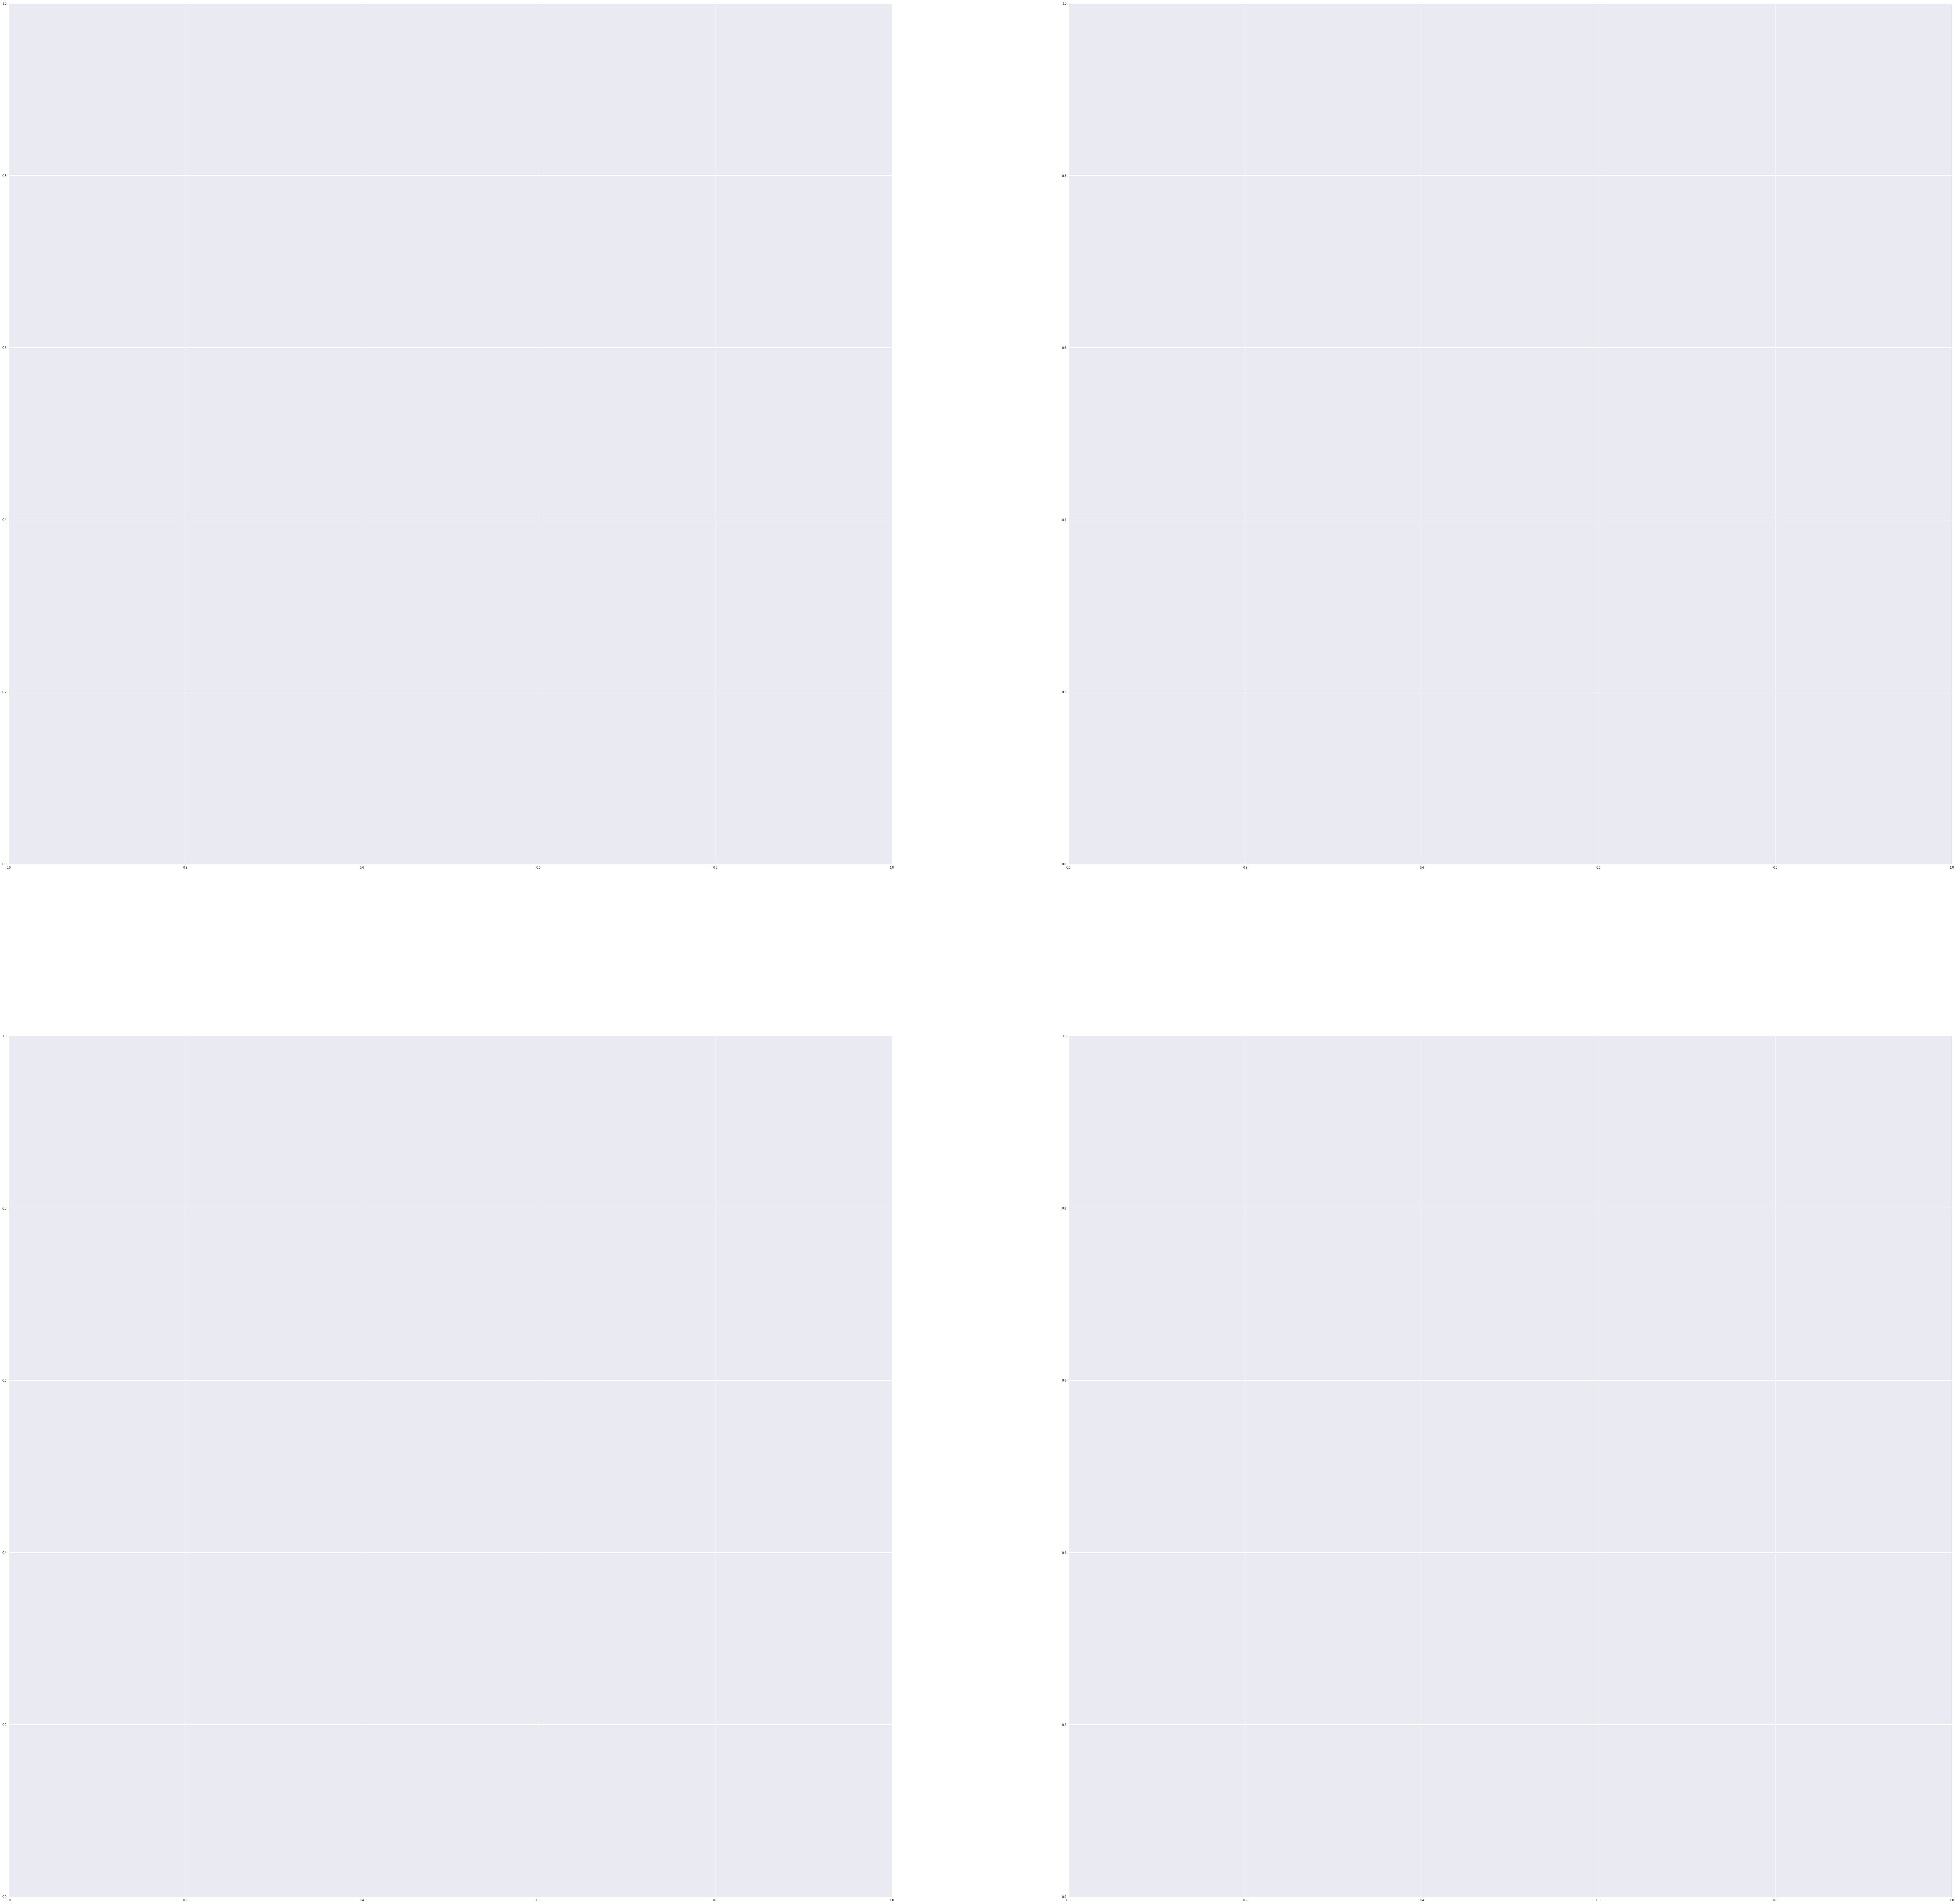

In [15]:
fig, axis = plt.subplots(2, 2, figsize=(114,114))
for image, (ax1, ax2) in zip(images, axis):
    fish = extract_fish(image, unet)
    ax1.imshow(image)
    ax2.imshow(fish)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
plt.show()

In [49]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import sys
sys.path.append('/content/fish-segmentation/src')
import numpy as np
import torch 
import torch.nn as nn
import os
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from sklearn.model_selection import train_test_split
from FishDataset import FishDataset
%load_ext autoreload
%autoreload 2
from model import UNet
train_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor()
])

train_dataset = FishDataset('../data', download=False, transform=train_transform, target_transform=train_transform)

train_indices, test_indices = train_test_split(np.arange(len(train_dataset)), test_size=0.2, random_state=42)
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=SubsetRandomSampler(train_indices),
    num_workers=4
)

val_loader = DataLoader(
    FishDataset('../data', transform=test_transform, target_transform=test_transform),
    batch_size=32,
    sampler=SubsetRandomSampler(train_indices),
    num_workers=4
)
def jaccard(outputs, targets):
    outputs = outputs.view(outputs.size(0), -1)
    targets = targets.view(targets.size(0), -1)
    intersection = (outputs * targets).sum(1)
    union = (outputs + targets).sum(1) - intersection
    jac = (intersection + 0.001) / (union + 0.001)
    return jac.mean()
model = UNet()
model.cuda()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
model_folder = os.path.abspath('/content/models')
if not os.path.exists(model_folder):
    os.mkdir(model_folder)
model_path = os.path.join(model_folder, 'unet.pt')
hist = {'loss': [], 'jaccard': [], 'val_loss': [], 'val_jaccard': []}
num_epochs = 5
display_steps = 50
best_jaccard = 0
for epoch in range(num_epochs):
    print('Starting epoch {}/{}'.format(epoch+1, num_epochs))
    # train
    model.train()
    running_loss = 0.0
    running_jaccard = 0.0
    for batch_idx, (images, masks, _) in enumerate(train_loader):
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        
        optimizer.zero_grad()
        outputs = model(images)
        predicted = outputs.round()
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        jac = jaccard(outputs.round(), masks)
        running_jaccard += jac.item()
        running_loss += loss.item()
        
        if batch_idx % display_steps == 0:
            print('    ', end='')
            print('batch {:>3}/{:>3} loss: {:.4f}, jaccard {:.4f}\r'\
                  .format(batch_idx+1, len(train_loader),
                          loss.item(), jac.item()))

        
    # evalute
    print('Finished epoch {}, starting evaluation'.format(epoch+1))
    model.eval()
    val_running_loss = 0.0
    val_running_jaccard = 0.0
    for images, masks, _ in val_loader:
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        val_running_loss += loss.item()
        jac = jaccard(outputs.round(), masks)
        val_running_jaccard += jac.item()

    train_loss = running_loss / len(train_loader)
    train_jaccard = running_jaccard / len(train_loader)
    val_loss = val_running_loss / len(val_loader)
    val_jaccard = val_running_jaccard / len(val_loader)
    
    hist['loss'].append(train_loss)
    hist['jaccard'].append(train_jaccard)
    hist['val_loss'].append(val_loss)
    hist['val_jaccard'].append(val_jaccard)
    
    if val_jaccard > best_jaccard:
        torch.save(model, model_path)
    print('    ', end='')
    print('loss: {:.4f}  jaccard: {:.4f} \
           val_loss: {:.4f} val_jaccard: {:4.4f}\n'\
           .format(train_loss, train_jaccard, val_loss, val_jaccard))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Starting epoch 1/5


/content/fish-segmentation/src/model.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(self.conv.weight, gain=np.sqrt(2))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  


    batch   1/685 loss: 0.7350, jaccard 0.1092
    batch  51/685 loss: 0.6700, jaccard 0.6339
    batch 101/685 loss: 0.6588, jaccard 0.7694
    batch 151/685 loss: 0.6536, jaccard 0.8048
    batch 201/685 loss: 0.6472, jaccard 0.8160
    batch 251/685 loss: 0.6446, jaccard 0.8045
    batch 301/685 loss: 0.6415, jaccard 0.8241
    batch 351/685 loss: 0.6378, jaccard 0.8092
    batch 401/685 loss: 0.6339, jaccard 0.8605
    batch 451/685 loss: 0.6335, jaccard 0.8617
    batch 501/685 loss: 0.6305, jaccard 0.8708
    batch 551/685 loss: 0.6359, jaccard 0.8124
    batch 601/685 loss: 0.6302, jaccard 0.8378
    batch 651/685 loss: 0.6283, jaccard 0.7989
Finished epoch 1, starting evaluation
    loss: 0.6431  jaccard: 0.8019            val_loss: 0.6298 val_jaccard: 0.8606

Starting epoch 2/5
    batch   1/685 loss: 0.6284, jaccard 0.8550
    batch  51/685 loss: 0.6271, jaccard 0.8780
    batch 101/685 loss: 0.6274, jaccard 0.8661
    batch 151/685 loss: 0.6251, jaccard 0.8774
    batch 201/